In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
from libpysal import weights, examples
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.spatial import distance

# Preprocesamiento y exploración

In [7]:
df = pd.read_csv("data/vehicle_gps.csv")
df

,vehicle,latitude,longitude,timestamp
0,A,-33.416709,-70.592693,01-01-2022 8:01
1,A,-33.417425,-70.592487,01-01-2022 8:02
2,A,-33.417831,-70.592367,01-01-2022 8:04
3,A,-33.417879,-70.592018,01-01-2022 8:05
4,A,-33.417818,-70.591653,01-01-2022 8:06
...,...,...,...,...
72,D,-33.419257,-70.586876,01-01-2022 8:22
73,D,-33.418902,-70.587003,01-01-2022 8:23
74,D,-33.418350,-70.587149,01-01-2022 8:23
75,D,-33.417943,-70.587252,01-01-2022 8:24


In [3]:
df.duplicated()

0     False
1     False
2     False
3     False
4     False
      ...  
72    False
73    False
74    False
75    False
76    False
Length: 77, dtype: bool

In [4]:
df.isnull().sum().sort_values(ascending=False) 

vehicle      0
latitude     0
longitude    0
timestamp    0
dtype: int64

In [11]:
#coordenadas = np.array(df[['latitude','longitude']])
posiciones = {i:np.array([df['longitude'][i], df['latitude'][i]]) for i,f in df.iterrows()}

In [6]:
df.vehicle.unique()

array(['A', 'B', 'C', 'D'], dtype=object)

# Funciones generales

In [52]:
# agrega un nodo al grafo en su posicion
def agregar_nodo (grafo, nombre, posicion):
    grafo.add_node(nombre, pos = (posicion[0],posicion[1]))
    
# toma dos fechas y calcula el tiempo entre ellas
def tiempo_entre_nodos(fecha_i, fecha_f):
    date1 = datetime.strptime(fecha_i, "%d-%m-%Y %H:%M")
    date2 = datetime.strptime(fecha_f, "%d-%m-%Y %H:%M")
    tiempo = abs(date2 - date1)
    tiempo_min = tiempo.total_seconds() / 60
    return tiempo_min

# toma un grafo, busca sus arcos en el dataframe y setea el peso de ese arco como el tiempo entre los nodos del arco
def setear_tiempos(G, df):
    for i in G.edges:
        fecha_i = df['timestamp'][i[0]]
        fecha_f = df['timestamp'][i[1]]
        G.add_edge(i[0], i[1], weight = tiempo_entre_nodos(fecha_i, fecha_f))
    return G

#graficar
def plotear(graph, df):
    posiciones = {i:np.array([df['longitude'][i], df['latitude'][i]]) for i,f in df.iterrows()}
    plt.figure(figsize=(8, 8))
    nx.draw(graph, posiciones, with_labels=True, arrowsize = 5, node_color='green', node_size=150)
    plt.axis('off')
    #plt.tight_layout()
    plt.show()

# Grafo


## Aproach base

In [115]:
# crea un grafo a partir de los datos entregados como DataFrame
# crea los arcos uniendo cada punto con su punto siguiente correspondiente
def grafo_base(df):
    grafo = nx.DiGraph()
    pos = {i : np.array([fila[2], fila[1]])for i, fila in df.iterrows()}
    for nodo in pos.keys():
        agregar_nodo(grafo, nodo, posiciones[nodo])
    #for nodo in pos.keys():
        if nodo < list(pos.keys())[-1]:
            grafo.add_edge(nodo, nodo+1)
    return grafo

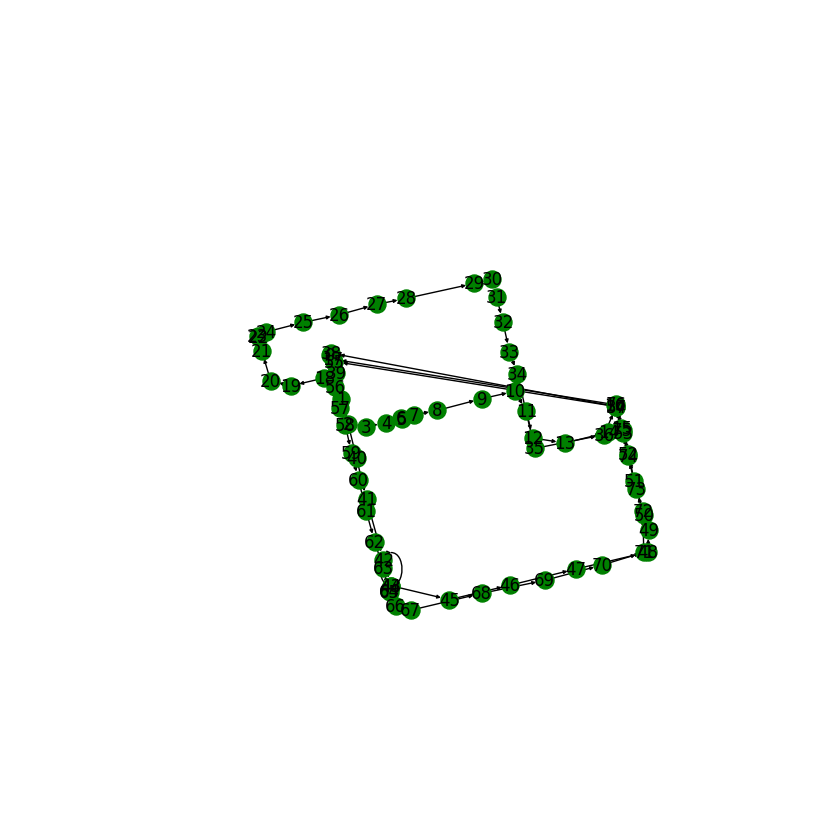

In [121]:
G = grafo_base(df)
plotear(G, df)


### Grafos por vehiculo

In [124]:
df_A = df[df['vehicle'] == 'A']
A = grafo_base(df_A)
setear_tiempos(A, df_A)
#plotear(A, df_A)
#A.edges(data=True)

In [123]:
df_B = df[df['vehicle'] == 'B']
B = grafo_base(df_B)
setear_tiempos(B, df_B)
#plotear(B, df_B)
#B.edges(data=True)

In [125]:
df_C = df[df['vehicle'] == 'C']
C = grafo_base(df_C)
setear_tiempos(C, df_C)
#plotear(C, df_C)
#C.edges(data=True)

In [97]:
df_D = df[df['vehicle'] == 'D']
D = grafo_base(df_D)
setear_tiempos(D, df_D)
#plotear(D, df_D)
D.edges(data=True)

OutEdgeDataView([(55, 56, {'weight': 1.0}), (56, 57, {'weight': 1.0}), (57, 58, {'weight': 1.0}), (58, 59, {'weight': 2.0}), (59, 60, {'weight': 1.0}), (60, 61, {'weight': 1.0}), (61, 62, {'weight': 2.0}), (62, 63, {'weight': 2.0}), (63, 64, {'weight': 1.0}), (64, 65, {'weight': 1.0}), (65, 66, {'weight': 2.0}), (66, 67, {'weight': 0.0}), (67, 68, {'weight': 2.0}), (68, 69, {'weight': 1.0}), (69, 70, {'weight': 2.0}), (70, 71, {'weight': 0.0}), (71, 72, {'weight': 1.0}), (72, 73, {'weight': 1.0}), (73, 74, {'weight': 0.0}), (74, 75, {'weight': 1.0}), (75, 76, {'weight': 0.0})])

### Grafo completo

> Supuesto: Para lograr hacer que el grafo sea un circuito completo y se pueda navegar desde cualquier punto a cualquier punto, los recorridos de B y C los tomé en el otro sentido

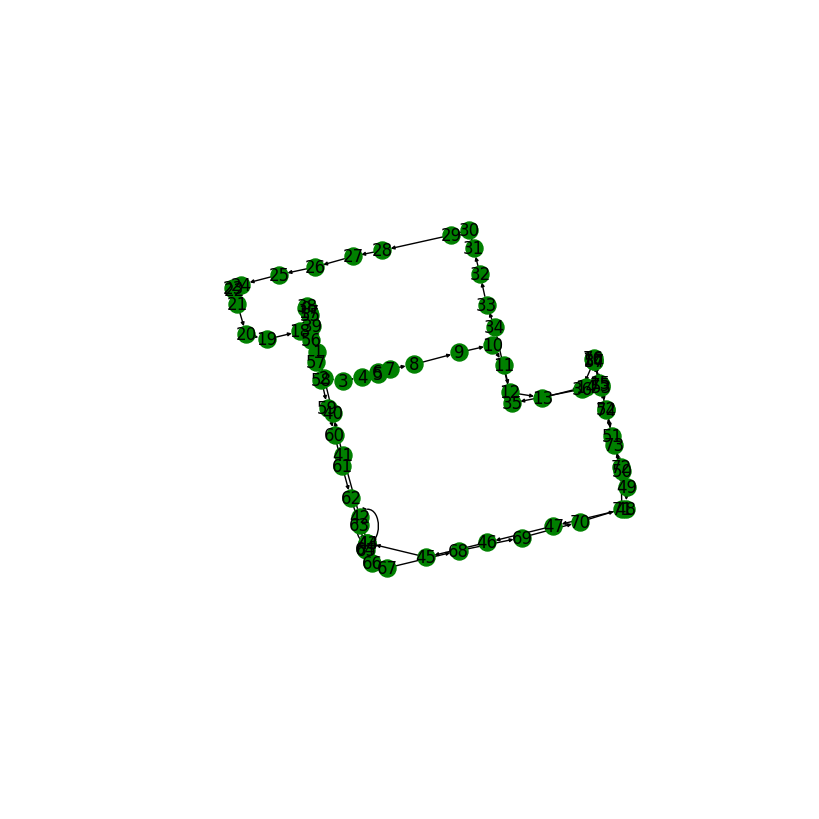

In [93]:
Br = B.reverse()
Cr = C.reverse()

# de esta forma uni los grafos en uno solo
grafo_completo = nx.compose(A,Br)
grafo_completo = nx.compose(grafo_completo, Cr)
grafo_completo = nx.compose(grafo_completo,D)

# de esta forma uni los sub grafos
# supe que eran estos los puntos que debía unir por inspección
# el final de B (invertido) con el inicio de A y D
# el final de C (invertido) con el inicio de A y D
# el final de A con el inicio de B y C (invertidos)
# el final de D con el inicio de B y C (invertidos)

grafo_completo.add_edge(list(Br.nodes)[0], list(A.nodes)[0])
grafo_completo.add_edge(list(Br.nodes)[0], list(D.nodes)[0])
grafo_completo.add_edge(list(Cr.nodes)[0], list(A.nodes)[0])
grafo_completo.add_edge(list(Cr.nodes)[0], list(D.nodes)[0])

grafo_completo.add_edge(list(A.nodes)[-1], list(Br.nodes)[-1])
grafo_completo.add_edge(list(A.nodes)[-1], list(Cr.nodes)[-1])
grafo_completo.add_edge(list(D.nodes)[-1], list(Br.nodes)[-1])
grafo_completo.add_edge(list(D.nodes)[-1], list(Cr.nodes)[-1])

#plotear(grafo_completo, df)


## Caso extra: distancia y knn [omitir]

/home/domingojara/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


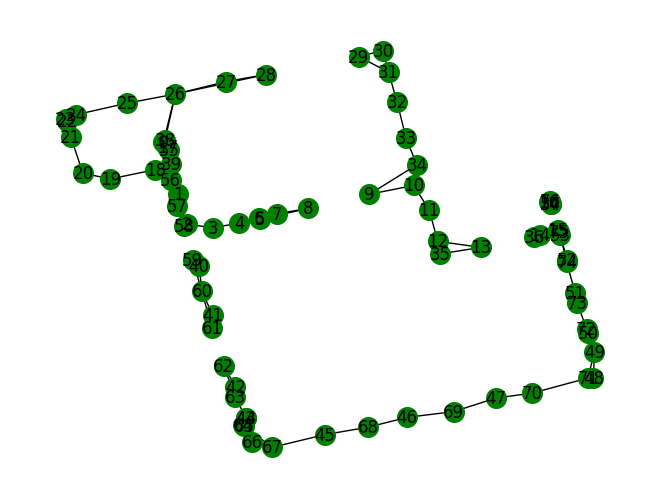

In [30]:
def knn(df):
    
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    knn2 = weights.KNN.from_dataframe(gdf, k=2)
    knn_di_graph = knn2.to_networkx()
    knn_graph = nx.Graph(knn_di_graph)
    
    nodos = knn2.id_order
    mapping = {i: nodos[i] for i in range(len(nodos))}
    knn_graph = nx.relabel_nodes(knn_graph, mapping)
    
    
    return knn_graph

knn_graph = knn(df)
plotear(knn_graph, df)

/home/domingojara/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 10 islands with ids: 9, 13, 25, 26, 27, 28, 45, 46, 68, 69.
  warnings.warn(message)


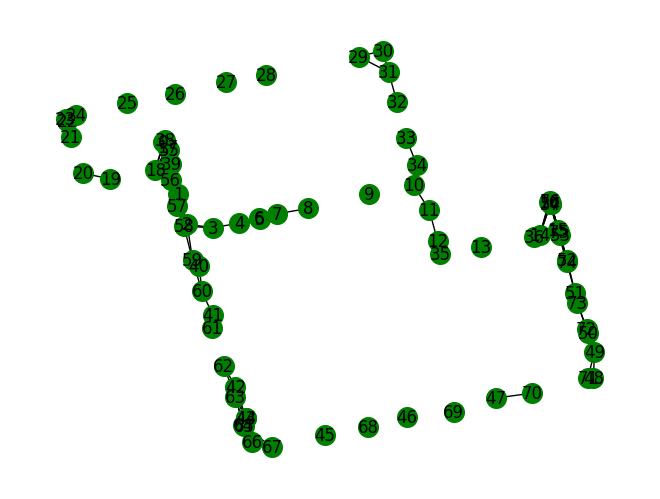

<class 'networkx.classes.graph.Graph'>


In [32]:
def dist(df):
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    coordinates = np.column_stack((gdf.geometry.x, gdf.geometry.y))
    dist = weights.DistanceBand.from_array(coordinates, threshold=0.0005)
    
    dist_graph = dist.to_networkx()
    return dist_graph

dist_graph = dist(df)
plotear(dist_graph, df)

In [28]:
#f, ax = plt.subplots(1, 2, figsize=(16, 8))
#for i, facet in enumerate(ax):
 #   gdf.plot(marker=".", color="orangered", ax=facet)
 #   facet.set_title(("KNN-2", "Distance based")[i])
#nx.draw(knn_graph, posiciones, ax=ax[0], with_labels=True, node_color='green', node_size=200)
#nx.draw(dist_graph, posiciones, ax=ax[1], with_labels=True, node_color='green', node_size=200)

#plt.show();

/home/domingojara/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)
/home/domingojara/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 10 islands with ids: 9, 13, 25, 26, 27, 28, 45, 46, 68, 69.
  warnings.warn(message)


### Caso separado por vehiculo

/home/domingojara/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


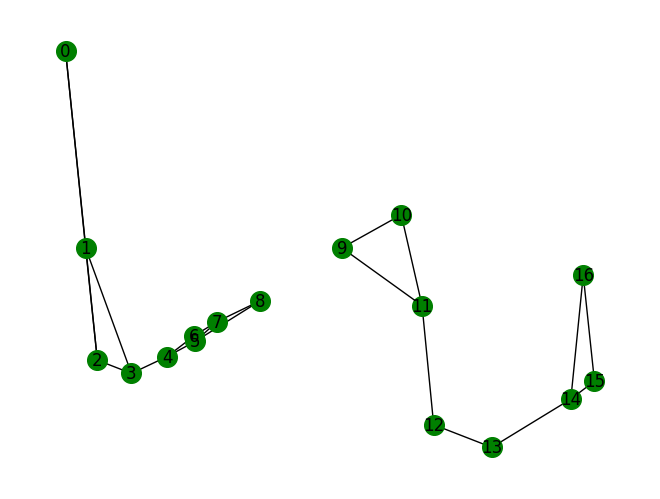

,vehicle,latitude,longitude,timestamp
0,A,-33.416709,-70.592693,01-01-2022 8:01
1,A,-33.417425,-70.592487,01-01-2022 8:02
2,A,-33.417831,-70.592367,01-01-2022 8:04
3,A,-33.417879,-70.592018,01-01-2022 8:05
4,A,-33.417818,-70.591653,01-01-2022 8:06
5,A,-33.417763,-70.591365,01-01-2022 8:07
6,A,-33.417742,-70.591373,01-01-2022 8:08
7,A,-33.417691,-70.591139,01-01-2022 8:09
8,A,-33.417616,-70.590700,01-01-2022 8:10
9,A,-33.417424,-70.589862,01-01-2022 8:11


In [559]:
df_A = df[df['vehicle'] == 'A']
knn_a = knn(df_A)
plotear(knn_a, df_A)
df_A

/home/domingojara/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


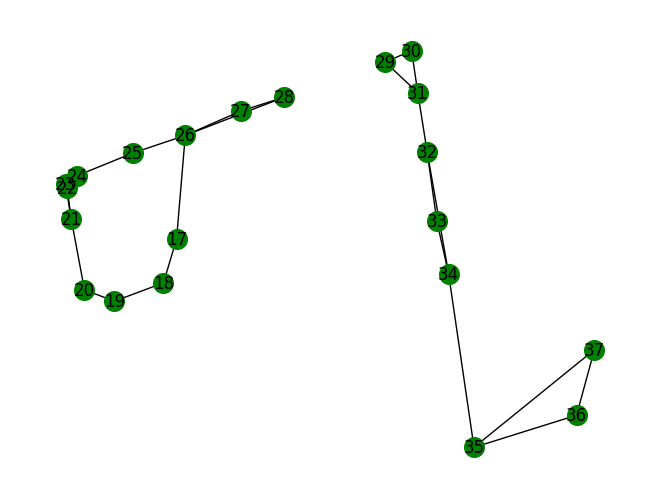

,vehicle,latitude,longitude,timestamp
17,B,-33.416783,-70.592640,01-01-2022 8:01
18,B,-33.417088,-70.592805,01-01-2022 8:01
19,B,-33.417216,-70.593424,01-01-2022 8:01
20,B,-33.417137,-70.593801,01-01-2022 8:02
21,B,-33.416644,-70.593968,01-01-2022 8:02
22,B,-33.416425,-70.594021,01-01-2022 8:03
23,B,-33.416398,-70.594040,01-01-2022 8:04
24,B,-33.416340,-70.593890,01-01-2022 8:05
25,B,-33.416183,-70.593192,01-01-2022 8:07
26,B,-33.416060,-70.592530,01-01-2022 8:07


In [560]:
df_B = df[df['vehicle'] == 'B']
knn_b = knn(df_B)
plotear(knn_b, df_B)
df_B

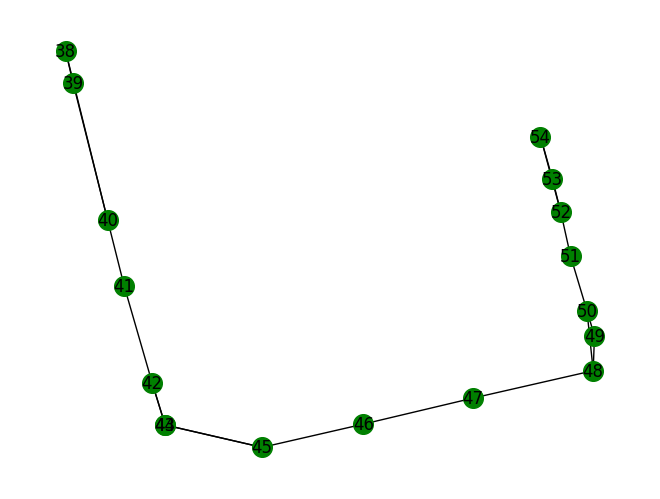

,vehicle,latitude,longitude,timestamp
38,C,-33.416686,-70.592672,01-01-2022 8:01
39,C,-33.417008,-70.592589,01-01-2022 8:01
40,C,-33.418396,-70.592203,01-01-2022 8:02
41,C,-33.419066,-70.592017,01-01-2022 8:03
42,C,-33.420047,-70.591704,01-01-2022 8:03
43,C,-33.420470,-70.591560,01-01-2022 8:04
44,C,-33.420470,-70.591560,01-01-2022 8:05
45,C,-33.420696,-70.590477,01-01-2022 8:06
46,C,-33.420461,-70.589346,01-01-2022 8:07
47,C,-33.420198,-70.588122,01-01-2022 8:09


In [561]:
df_C = df[df['vehicle'] == 'C']
knn_c = knn(df_C)
plotear(knn_c, df_C)
df_C

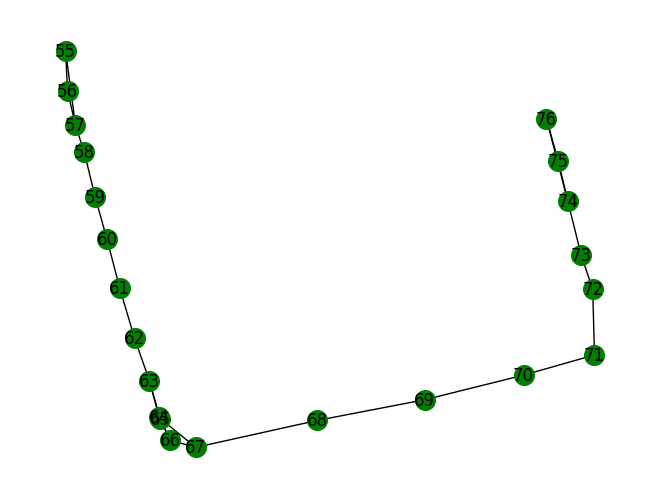

,vehicle,latitude,longitude,timestamp
55,D,-33.416820,-70.592617,01-01-2022 8:01
56,D,-33.417232,-70.592595,01-01-2022 8:02
57,D,-33.417581,-70.592509,01-01-2022 8:03
58,D,-33.417859,-70.592412,01-01-2022 8:04
59,D,-33.418316,-70.592294,01-01-2022 8:06
60,D,-33.418746,-70.592165,01-01-2022 8:07
61,D,-33.419247,-70.592026,01-01-2022 8:08
62,D,-33.419757,-70.591865,01-01-2022 8:10
63,D,-33.420187,-70.591704,01-01-2022 8:12
64,D,-33.420560,-70.591598,01-01-2022 8:13


In [562]:
df_D = df[df['vehicle'] == 'D']
knn_d = knn(df_D)
plotear(knn_d, df_D)
df_D

# Tiempo

In [126]:
# funcion que saca el punto mas cercano a cualquier punto de todos
# la idea es que alguien entregue sus coordenadas y esta funcion pone a esa persona en el grafo (en el punto mas cercano)
def punto_mas_cercano(posicion, df):
    posiciones = {i:np.array([df['longitude'][i], df['latitude'][i]]) for i,f in df.iterrows()}
    posicion = np.array(posicion)
    pos = np.array(list(posiciones.values()))
    distancias = distance.cdist([posicion], pos, 'euclidean')
    indice_cercano = np.argmin(distancias)
    keys = list(posiciones.keys())
    key_cercana = keys[indice_cercano]
    return key_cercana

# entrega el camino y el tiempo estimado [en minutos] del camino más corto entre 2 puntos
def camino_tiempo(G, pto_i, pto_f):
    camino = nx.shortest_path(G, pto_i, pto_f) 
    tiempo = nx.shortest_path_length(G, pto_i, pto_f)
    return camino, tiempo

In [129]:
# tomamos una posicion cualquiera, se calcula el punto en el grafo más cercano 
# y después se calcula el camino más rápido y su tiempo 
posicion = (-70.59666 , -33.41688)
punto_i = punto_mas_cercano(posicion, df)
punto_f = np.random.randint(0, 77)
camino_tiempo(grafo_completo, punto_i, punto_f)

([23, 22, 21, 20, 19, 18], 5)